In [100]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy, pickle

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')

from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import cost_functions as cost_functions
from neurolib.optimal_control import oc_wc

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
points_bi = [
    [2.9, 2.1], [2.9, 2.5], [2.9, 2.9], [2.9, 3.3],
    [3.3, 2.5], [3.3, 2.9], [3.3, 3.3],
    [3.7, 2.9], [3.7, 3.3],
    [4.1, 3.3],
]

In [102]:
def gettarget(targetstate):
    target = np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]
    target[0,0,:] = targetstate[0]
    target[0,1,:] = targetstate[1]

    return target

def setinit(initstate):
    wc.params["exc_init"] = np.array([[ initstate[0] ]])
    wc.params["inh_init"] = np.array([[ initstate[1] ]])

def decrease_step_compute():

    for pow in [-4, -5]:

        wc_controlled.step = 10**pow
        wc_controlled.zero_step_encountered = False
        wc_controlled.optimize(200)

def increase_step_compute():

    for pow in [-2, -1, 0, 2, 4]:

        wc_controlled.step = 10**pow
        wc_controlled.zero_step_encountered = False
        wc_controlled.optimize(200*(3 + pow))

    return

def get_values(results_dict, ip, w):
    results_dict["control"][ip] = wc_controlled.control.copy()
    results_dict["state"][ip] = wc_controlled.get_xs().copy()
    results_dict["cost"][ip] = wc_controlled.cost_history[-1]

    wc_controlled.w_2 = 0.
    wc_controlled.simulate_forward()
    results_dict["precision_cost"][ip] = wc_controlled.compute_total_cost()
    wc_controlled.w_2 = w

    ce = np.zeros((results_dict["control"][ip].shape))
    ce[0,0,:] = results_dict["control"][ip][0,0,:]
    results_dict["L_cost"][ip][0] = cost_functions.energy_cost(ce, 1., dt)
    ci = np.zeros((results_dict["control"][ip].shape))
    ci[0,1,:] = results_dict["control"][ip][0,1,:]
    results_dict["L_cost"][ip][1] = cost_functions.energy_cost(ci, 1., dt)

    return

def getmodel(t, w, results_dict, i):
    wc_controlled = oc_wc.OcWc(wc, target=t, w_p=1, w_2=w, print_array=[], precision_cost_interval=(int0,None), control_matrix=control_mat, precision_matrix=prec_mat)

    if type(results_dict["control"][i]) != type(None):
        wc_controlled.control = results_dict["control"][i].copy()
        wc_controlled.update_input()
    wc_controlled.model.run()    

    return wc_controlled


In [103]:
n_points = len(points_bi)
file_array = []
for i in range(len(points_bi)):
    file_array.append('w1_' + str(i+1) + '.png')

results_w2_du = dict([
    ('cost_type', 'w2'),
    ('point', [None] * n_points),
    ('d', [None] * n_points),
    ('u', [None] * n_points),
    ("cost", [None] * n_points),
    ("initial_cost", [None] * n_points),
    ("precision_cost", [None] * n_points),
    ("L_cost", [np.zeros((2))] * n_points),
    ("control", [None] * n_points),
    ("state", [None] * n_points),
    ("filename", file_array)
    ])

def save(results_dict):
    filehandler = open("l2_du.pickle","wb")
    pickle.dump(results_dict,filehandler)
    filehandler.close()

In [104]:
with open('l2_du.pickle', 'rb') as f:
    results_w2_du = pickle.load(f)

In [105]:
wc = WCModel()
wc.params.sigma_ou = 0.
dt = 0.1
wc.params.dt = dt
duration = 500.
wc.params["duration"] = duration

zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
bi_control = zero_input.copy()
bi_control[0,:500] = -5.
bi_control[0,2500:3000] = +5.

for i in range(len(points_bi)):

    p = points_bi[i]
    results_w2_du['point'][i] = p

    wc.params["exc_ext"] = bi_control + p[0]
    wc.params["inh_ext"] = zero_input + p[1]
    wc.run()

    results_w2_du['d'][i] = [wc.exc[0,2000], wc.inh[0,2000]]
    results_w2_du['u'][i] = [wc.exc[0,-1], wc.inh[0,-1]]

    #plt.plot(wc.exc[0,:])
    #plt.show()

In [139]:
int0 = 1800
w1 = 1.

control_mat = np.zeros( (wc.params.N, len(wc.state_vars)) )
control_mat[0,0] = 1.
control_mat[0,1] = 1.

prec_mat = np.zeros( (wc.params.N, len(wc.output_vars)) )
prec_mat[0,0] = 1.
prec_mat[0,1] = 1.

duration = 200.
wc.params["duration"] = duration
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)

for i in range(len(points_bi)):

    print("POINT ", i+1)

    if i not in [2]:
        continue

    p = points_bi[i]

    wc.params["exc_ext"] = zero_input + p[0]
    wc.params["inh_ext"] = zero_input + p[1]

    target = gettarget( results_w2_du['u'][i] )
    setinit( results_w2_du['d'][i] )

    #if type(results_w2_du["control"][i]) != type(None):
    #    continue

    #results_w2_du["control"][i] = None
        
    wc_controlled = getmodel(target, w1, results_w2_du, i)

    if False:

        wc_controlled.step = 1e-3
        wc_controlled.optimize(1)

        results_w2_du["initial_cost"][i] = wc_controlled.cost_history[0]

        wc_controlled.control[0,0,-300:-200] = 5.
        wc_controlled.update_input()

        wc_controlled.step = 1e-2
        wc_controlled.optimize(100)

        increase_step_compute()

        ce = wc_controlled.cost_history[-1]
        control_e = wc_controlled.control.copy()

        wc_controlled.control[0,0,:] = 0.
        wc_controlled.control[0,1,-300:-200] = -5.
        wc_controlled.update_input()

        wc_controlled.step = 1e-2
        wc_controlled.optimize(100)

        increase_step_compute()

        ci = wc_controlled.cost_history[-1]

        if ce <= ci:
            wc_controlled.control = control_e.copy()
            wc_controlled.update_input()

        wc_controlled.optimize(0)    
        get_values(results_w2_du, i, w1)    

    if True:
        for j in range(8, -20, -2):
            wc_controlled.step = 10**(j)
            wc_controlled.optimize(100)

            if results_w2_du["cost"][i] > wc_controlled.cost_history[-1]:
                get_values(results_w2_du, i, w1)
                save(results_w2_du)
                print("get values")

    for ki in range(0):

        for k in range(100):
            print(k)
            c0 = np.zeros((wc_controlled.control.shape))
            c0[0,:,:-100] = results_w2_du['control'][i][0,:,100:].copy()
            wc_controlled.control = c0.copy()
            wc_controlled.update_input()
            wc_controlled.optimize(0)
            wc_controlled.step_factor = 0.8

            for j in range(8, -20, -2):
                wc_controlled.step = 10**(j)
                wc_controlled.optimize(100)

            if results_w2_du["cost"][i] > wc_controlled.cost_history[-1]:
                get_values(results_w2_du, i, w1)
                save(results_w2_du)
            else: break

        for k in range(100):
            print(k)
            c0 = np.zeros((wc_controlled.control.shape))
            c0[0,:,:-10] = results_w2_du['control'][i][0,:,10:].copy()
            wc_controlled.control = c0.copy()
            wc_controlled.update_input()
            wc_controlled.optimize(0)
            wc_controlled.step_factor = 0.8

            for j in range(8, -20, -2):
                wc_controlled.step = 10**(j)
                wc_controlled.optimize(100)

            if results_w2_du["cost"][i] >= wc_controlled.cost_history[-1]:
                get_values(results_w2_du, i, w1)
                save(results_w2_du)
            else: break

        for k in range(100):
            print(k)
            c0 = np.zeros((wc_controlled.control.shape))
            c0[0,:,:-1] = results_w2_du['control'][i][0,:,1:].copy()
            wc_controlled.control = c0.copy()
            wc_controlled.update_input()
            wc_controlled.optimize(0)
            wc_controlled.step_factor = 0.8

            for j in range(8, -20, -2):
                wc_controlled.step = 10**(j)
                wc_controlled.optimize(100)

            if results_w2_du["cost"][i] >= wc_controlled.cost_history[-1]:
                get_values(results_w2_du, i, w1)
                save(results_w2_du)
            else: break

        print("increase amplitude")
        c0 = np.zeros((wc_controlled.control.shape))
        c0[0,:,:-1] = (1. + 1e-10) * results_w2_du['control'][i][0,:,1:].copy()
        wc_controlled.control = c0.copy()
        wc_controlled.update_input()
        wc_controlled.optimize(0)
        wc_controlled.step_factor = 0.8

        for j in range(8, -20, -2):
            wc_controlled.step = 10**(j)
            wc_controlled.optimize(100)

        if results_w2_du["cost"][i] > wc_controlled.cost_history[-1]:
            get_values(results_w2_du, i, w1)
            save(results_w2_du)
        else: break

    for k in range(0):
        print("forward shift")
        c0 = np.zeros((wc_controlled.control.shape))
        c0[0,:,10:] = results_w2_du['control'][i][0,:,:-10].copy()
        wc_controlled.control = c0.copy()
        wc_controlled.update_input()
        wc_controlled.optimize(0)
        wc_controlled.step_factor = 0.8

        for j in range(8, -20, -2):
            wc_controlled.step = 10**(j)
            wc_controlled.optimize(100)

        if results_w2_du["cost"][i] > wc_controlled.cost_history[-1]:
            get_values(results_w2_du, i, w1)
            save(results_w2_du)
            print("--------------- SUCCESS")
        else: break

    for k in range(20):
        print("forward shift")
        c0 = np.zeros((wc_controlled.control.shape))
        c0[0,:,1:] = results_w2_du['control'][i][0,:,:-1].copy()
        wc_controlled.control = c0.copy()
        wc_controlled.update_input()
        wc_controlled.optimize(0)
        wc_controlled.step_factor = 0.8

        for j in range(8, -20, -2):
            wc_controlled.step = 10**(j)
            wc_controlled.optimize(100)

        if results_w2_du["cost"][i] >= wc_controlled.cost_history[-1]:
            get_values(results_w2_du, i, w1)
            save(results_w2_du)
            print("--------------- SUCCESS")
        else: break

    save(results_w2_du)

POINT  1
POINT  2
POINT  3
Compute control for a deterministic system
Cost in iteration 0: 1.2552244337667064
Converged in iteration 1 with cost 1.2552244337667064 because of step counter
Final cost : 1.2552244337667064
Compute control for a deterministic system
Cost in iteration 0: 1.2552244337667064
Converged in iteration 1 with cost 1.2552244337667064 because of step counter
Final cost : 1.2552244337667064
Compute control for a deterministic system
Cost in iteration 0: 1.2552244337667064
Converged in iteration 1 with cost 1.2552244337667064 because of step counter
Final cost : 1.2552244337667064
Compute control for a deterministic system
Cost in iteration 0: 1.2552244337667064
Converged in iteration 1 with cost 1.2552244337667064 because of step counter
Final cost : 1.2552244337667064
Compute control for a deterministic system
Cost in iteration 0: 1.2552244337667064
Converged in iteration 1 with cost 1.2552244337667064 because of step counter
Final cost : 1.2552244337667064
Compute 

In [ ]:
save(results_w2_du)

POINT  1
POINT  2
POINT  3
1.2214783693188997
1.2552244337667064 2.794785708126736


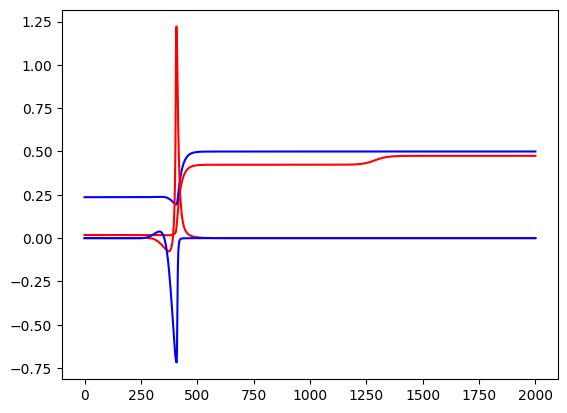

POINT  4
POINT  5
POINT  6
POINT  7
POINT  8
POINT  9
POINT  10


In [128]:
for i in range(len(points_bi)):
    print("POINT ", i+1)
    if i not in [2]:
        continue
    print(np.amax(results_w2_du["control"][i]))
    print(results_w2_du["cost"][i], results_w2_du["initial_cost"][i])
    plt.plot(results_w2_du["state"][i][0,0,:], color="red", linestyle='-')
    plt.plot(results_w2_du["state"][i][0,1,:], color="blue", linestyle='-')
    plt.plot(results_w2_du["control"][i][0,0,:], color="red")
    plt.plot(results_w2_du["control"][i][0,1,:], color="blue")
    plt.show()

POINT  1
POINT  2
POINT  3
Compute control for a deterministic system
Cost in iteration 0: 4.050010141766178
Final cost : 4.050010141766178
Compute control for a deterministic system
Cost in iteration 0: 4.050010141766178
Final cost : 1.3065788545248953
Compute control for a deterministic system
Cost in iteration 0: 1.3065788545248953
Final cost : 1.3013629517872825
Compute control for a deterministic system
Cost in iteration 0: 1.3013629517872825
Converged in iteration 1 with cost 1.3013629517872825 because of step counter
Final cost : 1.3013629517872825
Compute control for a deterministic system
Cost in iteration 0: 1.3013629517872825
Converged in iteration 1 with cost 1.3013629517872825 because of step counter
Final cost : 1.3013629517872825
Compute control for a deterministic system
Cost in iteration 0: 1.3013629517872825
Converged in iteration 1 with cost 1.3013629517872825 because of step counter
Final cost : 1.3013629517872825
Compute control for a deterministic system
Cost in i

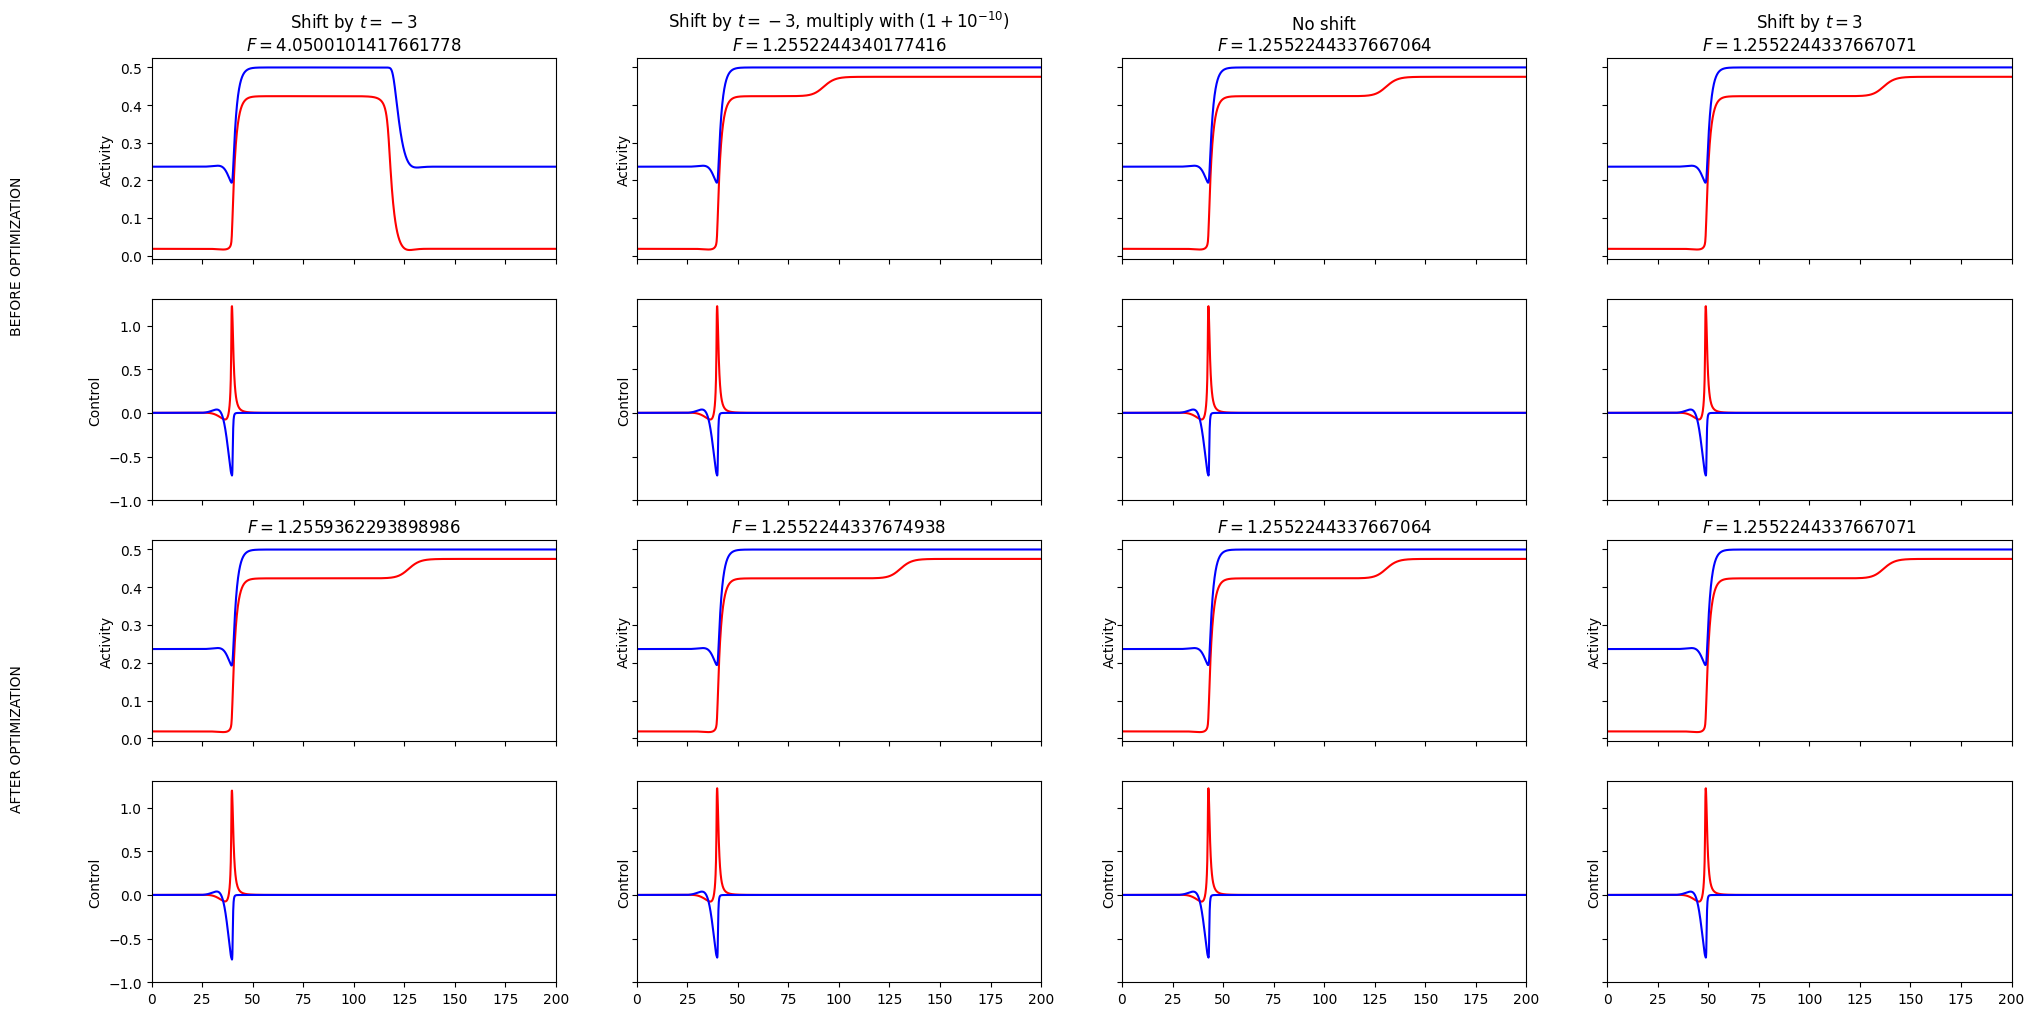

POINT  4
POINT  5
POINT  6
POINT  7
POINT  8
POINT  9
POINT  10


In [145]:
time = np.arange(0,200+dt,dt)
ish = 30

for i in range(len(points_bi)):

    print("POINT ", i+1)

    if i not in [2]:
        continue

    p = points_bi[i]

    wc.params["exc_ext"] = zero_input + p[0]
    wc.params["inh_ext"] = zero_input + p[1]

    target = gettarget( results_w2_du['u'][i] )
    setinit( results_w2_du['d'][i] )
        
    wc_controlled = getmodel(target, w1, results_w2_du, i)  

    fig, ax = plt.subplots(4, 4, figsize=(24,12), sharey="row", sharex=True)

    for j in range(4):
        ax[1,j].set_ylim([-1., 1.3])
        ax[3,j].set_ylim([-1., 1.3])

    ax[0,0].set_xlim(0,200)

    if True:
        col = 0

        c0 = np.zeros((wc_controlled.control.shape))
        c0[0,:,:-ish] = results_w2_du['control'][i][0,:,ish:].copy()
        wc_controlled.control = c0.copy()
        wc_controlled.update_input()
        wc_controlled.optimize(0)

        ax[0,col].set_title(r"Shift by $t=-3$" + "\n" + r"$F=$" + "{:.16f}".format(wc_controlled.compute_total_cost()) )
        ax[0,col].plot(time, wc_controlled.get_xs()[0,0,:], color="red")
        ax[0,col].plot(time, wc_controlled.get_xs()[0,1,:], color="blue")
        ax[0,col].set_ylabel("Activity")
        ax[1,col].plot(time, wc_controlled.control[0,0,:], color="red")
        ax[1,col].plot(time, wc_controlled.control[0,1,:], color="blue")
        ax[1,col].set_ylabel("Control")

        decrease_step_compute()

        wc_controlled.step_factor = 0.8

        for k in range(8, -20, -2):
            wc_controlled.step = 10**(k)
            wc_controlled.optimize(100)

        ax[2,col].plot(time, wc_controlled.get_xs()[0,0,:], color="red")
        ax[2,col].plot(time, wc_controlled.get_xs()[0,1,:], color="blue")
        ax[2,col].set_title(r"$F=$" + "{:.16f}".format(wc_controlled.cost_history[-1]) )
        ax[2,col].set_ylabel("Activity")
        ax[3,col].plot(time, wc_controlled.control[0,0,:], color="red")
        ax[3,col].plot(time, wc_controlled.control[0,1,:], color="blue")
        ax[3,col].set_ylabel("Control")    

    if True:
        col = 1

        c0 = np.zeros((wc_controlled.control.shape))
        factor =  1e-10
        c0[0,:,:-ish] = (1. + factor) * results_w2_du['control'][i][0,:,ish:].copy()
        wc_controlled.control = c0.copy()
        wc_controlled.update_input()
        wc_controlled.optimize(1)

        ax[0,col].set_title(r"Shift by $t=-3$, multiply with $(1 + 10^{-10})$" + "\n" + r"$F=$" + "{:.16f}".format(wc_controlled.compute_total_cost()) )
        ax[0,col].plot(time, wc_controlled.get_xs()[0,0,:], color="red")
        ax[0,col].plot(time, wc_controlled.get_xs()[0,1,:], color="blue")
        ax[0,col].set_ylabel("Activity")
        ax[1,col].plot(time, wc_controlled.control[0,0,:], color="red")
        ax[1,col].plot(time, wc_controlled.control[0,1,:], color="blue")
        ax[1,col].set_ylabel("Control")

        decrease_step_compute()

        wc_controlled.step_factor = 0.8

        for k in range(8, -20, -2):
            wc_controlled.step = 10**(k)
            wc_controlled.optimize(100)

        ax[2,col].plot(time, wc_controlled.get_xs()[0,0,:], color="red")
        ax[2,col].plot(time, wc_controlled.get_xs()[0,1,:], color="blue")
        ax[2,col].set_title(r"$F=$" + "{:.16f}".format(wc_controlled.cost_history[-1]) )
        ax[2,col].set_ylabel("Activity")
        ax[3,col].plot(time, wc_controlled.control[0,0,:], color="red")
        ax[3,col].plot(time, wc_controlled.control[0,1,:], color="blue")
        ax[3,col].set_ylabel("Control")  

    if True:
        col = 2  

        wc_controlled.control = results_w2_du['control'][i].copy()
        wc_controlled.update_input()
        wc_controlled.simulate_forward()

        ax[0,col].set_title(r"No shift" + "\n" +  r"$F=$" + "{:.16f}".format(wc_controlled.compute_total_cost()) )
        ax[0,col].plot(time, wc_controlled.get_xs()[0,0,:], color="red")
        ax[0,col].plot(time, wc_controlled.get_xs()[0,1,:], color="blue")
        ax[1,col].plot(time, wc_controlled.control[0,0,:], color="red")
        ax[1,col].plot(time, wc_controlled.control[0,1,:], color="blue")

        decrease_step_compute()

        wc_controlled.step_factor = 0.8

        for k in [4, 2, 0, -2, -4, -6, -8, -10, -12. -14, -16]:
            wc_controlled.step = 10**(k)
            wc_controlled.optimize(100)

        ax[2,col].plot(time, wc_controlled.get_xs()[0,0,:], color="red")
        ax[2,col].plot(time, wc_controlled.get_xs()[0,1,:], color="blue")
        ax[2,col].set_title(r"$F=$" + "{:.16f}".format(wc_controlled.cost_history[-1]) )
        ax[2,col].set_ylabel("Activity")
        ax[3,col].plot(time, wc_controlled.control[0,0,:], color="red")
        ax[3,col].plot(time, wc_controlled.control[0,1,:], color="blue")
        ax[3,col].set_ylabel("Control")  

    if True:
        col = 3

        ish = 60
        c0 = np.zeros((wc_controlled.control.shape))
        c0[0,:,ish:] = results_w2_du['control'][i][0,:,:-ish].copy()
        wc_controlled.control = c0.copy()
        wc_controlled.update_input()
        wc_controlled.optimize(1)
        ax[0,col].set_title(r"Shift by $t=3$" + "\n" + r"$F=$" + "{:.16f}".format(wc_controlled.compute_total_cost()) )
        ax[0,col].plot(time, wc_controlled.get_xs()[0,0,:], color="red")
        ax[0,col].plot(time, wc_controlled.get_xs()[0,1,:], color="blue")
        ax[1,col].plot(time, wc_controlled.control[0,0,:], color="red")
        ax[1,col].plot(time, wc_controlled.control[0,1,:], color="blue")

        decrease_step_compute()

        wc_controlled.step_factor = 0.8

        for k in [-6, -8, -10, -12. -14, -16]:
            wc_controlled.step = 10**(k)
            wc_controlled.optimize(100)

        ax[2,col].plot(time, wc_controlled.get_xs()[0,0,:], color="red")
        ax[2,col].plot(time, wc_controlled.get_xs()[0,1,:], color="blue")
        ax[2,col].set_title(r"$F=$" + "{:.16f}".format(wc_controlled.cost_history[-1]) )
        ax[2,col].set_ylabel("Activity")
        ax[3,col].plot(time, wc_controlled.control[0,0,:], color="red")
        ax[3,col].plot(time, wc_controlled.control[0,1,:], color="blue")
        ax[3,col].set_ylabel("Control")  


    ax[0,0].text(-70., 0., "BEFORE OPTIMIZATION", rotation=90, va='center')
    ax[2,0].text(-70., 0., "AFTER OPTIMIZATION", rotation=90, va='center')

    plt.show()